In [2]:
from IPython.display import Image
import pandas as pd
import graphviz as gv
from pprint import pprint
import requests
import json
from functools import reduce

# Orange Team TIDBIT 

# WF2 Mod1B Fanconi Anemia

In [3]:
input_disease = 'MONDO:0019391' # Fanconi anemia 
# load set of gene ids from module 0 (disease-gene lookup)
input_curie_set = ''
with open('input_curie_set.json', 'r') as ics:
    input_curie_set = json.load(ics)

# Mod1B Phenotype Similarity
## Find similar genes based on HP phenotype annotations and using the structure 

The phenotype similarity module takes the phenotype annotations for each gene associated with the input disease (in this case Human Phenotype Ontology terms), and does a comparison of phenotype associations to all other genes in the human genome.  Gene phenotypes are curated from literature and assigned to genes using the Human Phenotype Ontology. If a gene has a set of phenotypes assigned to it, that set of phenotypes can be pairwise compared to the sets of phenotype in every gene to determine a similarity score based on Jaccard Index. A simple algorithm that computes the length of the intersection of 2 sets over the length of their union.  

The ontology structure of the Human Phenotype Ontology is leveraged to include a higher level of context and meaning associated with each term annotated to the genes.  For example, two genes might have very similar terms, but not exact matches.  If Jaccard Index was used to compare those annotations at face value, they would not add be computed as similar in any way.  If the structure of the ontology is taken in to consideration then the two terms would be found to share a common close ancestor, and those ancestoral terms would be taken into consideration adding to similarity when the analysis is computed.

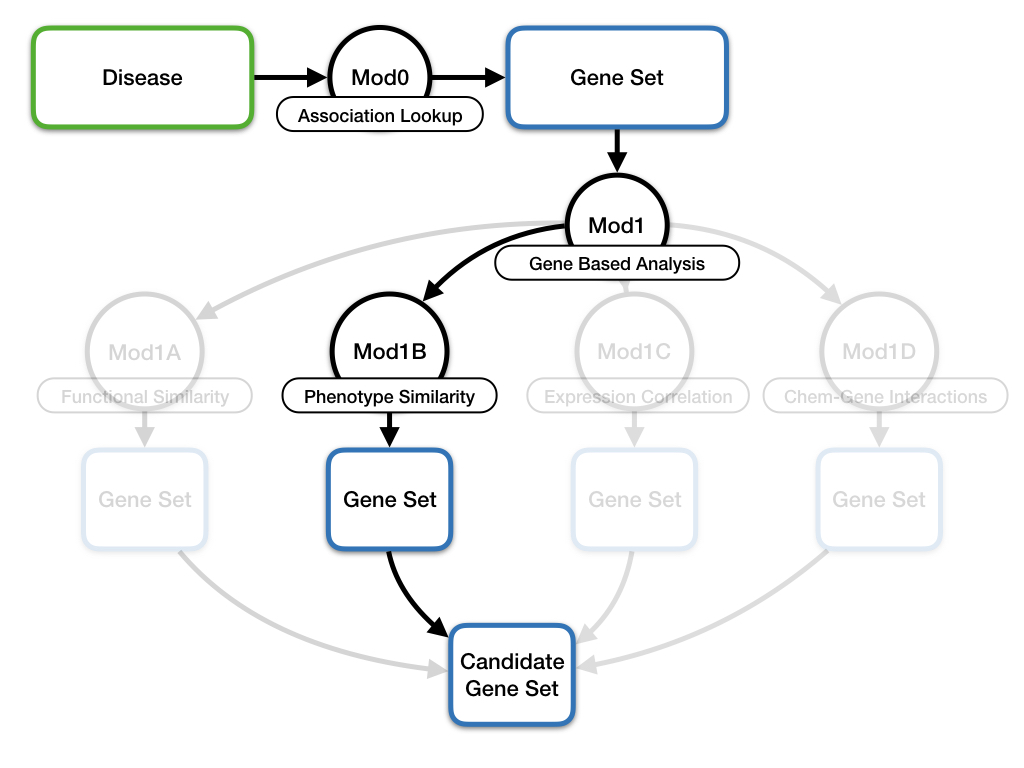

In [4]:
Image('Figures/Figures.015.jpeg')

In [5]:
from Modules.Mod1B1_phenotype_similarity import PhenotypeSimilarity

# Module instantiation
Here the functional similarity module is instantiated with a standard configuration object that includes the set of input genes as well as a threshold for the Jaccard index required to return a result.

In [6]:
# Module specification
mod1b_input_object_human = {
    'input': input_curie_set,
    'parameters': {
        'taxon': 'human',
        'threshold': 0.5,  # jaccard index threshold
    },
}
    
pheno_sim_human = PhenotypeSimilarity()

Mod1B Phenotype Similarity metadata:
{'input_type': {'complexity': 'set', 'data_type': 'gene', 'id_type': 'HGNC'},
 'output_type': {'complexity': 'set', 'data_type': 'gene', 'id_type': 'HGNC'},
 'predicate': ['blm:has phenotype'],
 'source': 'Monarch Biolink'}


In [7]:
pheno_sim_human.load_input_object(mod1b_input_object_human)
pheno_sim_human.load_gene_set() 

In [8]:
pheno_sim_human.load_associations()

In [9]:
mod1b_results = pheno_sim_human.compute_similarity()

In [10]:
mod1b_results = pheno_sim_human.compute_similarity()
mod1b_df = pd.DataFrame(mod1b_results)
mod1b_df = mod1b_df[mod1b_df['hit_symbol'] != mod1b_df['input_symbol']]
mod1b_df = mod1b_df[mod1b_df['hit_symbol'] != mod1b_df['input_symbol']]

# Results
Below are the results, a table of 'hits' that have a phenotype similarity Jaccard Index > .5 to any of the genes from the input gene set.

In [11]:
mod1b_df = mod1b_df[~mod1b_df['hit_id'].isin([x['hit_id'] for x in input_curie_set])]
mod1b_df

,hit_id,hit_symbol,input_id,input_symbol,score
36,HGNC:8143,OPCML,HGNC:20473,BRIP1,0.506767
38,HGNC:17271,RRAS2,HGNC:20473,BRIP1,0.506767
43,HGNC:7499,MT-TT,HGNC:20473,BRIP1,0.506767
282,HGNC:8143,OPCML,HGNC:26144,PALB2,0.501488
284,HGNC:17271,RRAS2,HGNC:26144,PALB2,0.501488
289,HGNC:7499,MT-TT,HGNC:26144,PALB2,0.501488


In [12]:
def format_curie(curie):
    return curie.replace(':', '_')

In [13]:
fa = format_curie(input_disease)

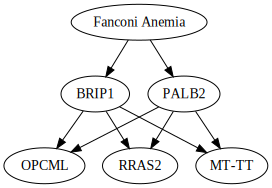

In [14]:
m1b_graph = gv.Digraph(name='Mod1B', format='png', strict=True)
m1b_graph.node(fa, label='Fanconi Anemia')
for index, row in mod1b_df.iterrows():
    m1b_graph.node(format_curie(row[0]), label=row[1])
    m1b_graph.node(format_curie(row[2]), label=row[3])
    m1b_graph.edge(fa, format_curie(row[2]))
    m1b_graph.edge(format_curie(row[2]), format_curie(row[0]))
m1b_graph   

In [15]:
OPCML_result_df = mod1b_df[mod1b_df['hit_symbol'] == 'OPCML']

In [16]:
OPCML_result_df

,hit_id,hit_symbol,input_id,input_symbol,score
36,HGNC:8143,OPCML,HGNC:20473,BRIP1,0.506767
282,HGNC:8143,OPCML,HGNC:26144,PALB2,0.501488


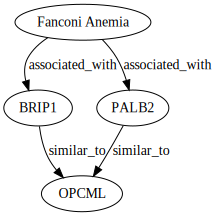

In [17]:
OPCML_graph = gv.Digraph(name='OPCML', format='png', strict=True)
OPCML_graph.node(fa, label='Fanconi Anemia')
for index, row in OPCML_result_df.iterrows():
    OPCML_graph.node(format_curie(row[0]), label=row[1])
    OPCML_graph.node(format_curie(row[2]), label=row[3])
    OPCML_graph.edge(fa, format_curie(row[2]), label='associated_with')
    OPCML_graph.edge(format_curie(row[2]), format_curie(row[0]), label='similar_to')
OPCML_graph   

In [18]:
OPCML_functions = [
    {
        'label': pheno_sim_human.ontology.label(x), 
        'id': x
    } for x in pheno_sim_human.associations.annotations('HGNC:8143') ]
BRIP1_functions = [
    {
        'label': pheno_sim_human.ontology.label(x), 
        'id': x,
    } for x in pheno_sim_human.associations.annotations('HGNC:20473') ]


In [19]:
def graph_functions(input_node, annotations, graph):
    for anno in annotations:
        graph.node(format_curie(anno['id']), anno['label'])
        graph.edge(format_curie(input_node), format_curie(anno['id']), label='has_function')

In [20]:
graph_functions('HGNC:8143', OPCML_functions, OPCML_graph)
graph_functions('HGNC:20473', BRIP1_functions, OPCML_graph)

In [21]:
brip1_inferred_functions = []
for bfunc in BRIP1_functions:
    brip1_inferred_functions = brip1_inferred_functions + pheno_sim_human.ontology.ancestors(bfunc['id'], reflexive=True)

In [22]:
opcml_inferred_functions = []
for ifunc in OPCML_functions:
    opcml_inferred_functions = opcml_inferred_functions + pheno_sim_human.ontology.ancestors(ifunc['id'], reflexive=True)

In [23]:
OPCML_functions

[{'label': 'Amenorrhea', 'id': 'HP:0000141'},
 {'label': 'Immunodeficiency', 'id': 'HP:0002721'},
 {'label': 'Severe combined immunodeficiency', 'id': 'HP:0004430'},
 {'label': 'Neutropenia', 'id': 'HP:0001875'},
 {'label': 'Dehydration', 'id': 'HP:0001944'},
 {'label': 'Abdominal pain', 'id': 'HP:0002027'},
 {'label': 'Pleural effusion', 'id': 'HP:0002202'},
 {'label': 'Neuroendocrine neoplasm', 'id': 'HP:0100634'},
 {'label': 'Dyspnea', 'id': 'HP:0002094'},
 {'label': 'Testicular atrophy', 'id': 'HP:0000029'},
 {'label': 'Obesity', 'id': 'HP:0001513'},
 {'label': 'Hyperthyroidism', 'id': 'HP:0000836'},
 {'label': 'Abnormality of metabolism/homeostasis', 'id': 'HP:0001939'},
 {'label': 'Gonadal neoplasm', 'id': 'HP:0010785'},
 {'label': 'Overgrowth', 'id': 'HP:0001548'},
 {'label': 'Hypertension', 'id': 'HP:0000822'},
 {'label': 'Neoplasm of the liver', 'id': 'HP:0002896'},
 {'label': 'Elevated circulating parathyroid hormone level',
  'id': 'HP:0003165'},
 {'label': 'Epididymitis', '

In [24]:
phenotype_graph = gv.Digraph(name='Phenotype Graph', strict=True, format='png', engine='circo')
phenotype_graph.node(format_curie('HGNC:8143'),
                     label='OPCML',
                     color='blue', 
                     shape='box', 
                     fontsize='25'
                    )
phenotype_graph.node(format_curie('HGNC:20473'),
                     label='BRIP1',
                     color='blue', 
                     shape='box', 
                     fontsize='25'
                    )

In [25]:
for index, ifunc in enumerate(opcml_inferred_functions):
    try:
        phenotype_graph.node(format_curie(ifunc), label=pheno_sim_human.ontology.label(ifunc))
        phenotype_graph.edge(format_curie('HGNC:8143'), format_curie(ifunc))
    except Exception as e:
        print(e)
for index, bfunc in enumerate(brip1_inferred_functions):
    try:
        phenotype_graph.node(format_curie(bfunc), label=pheno_sim_human.ontology.label(bfunc))
        phenotype_graph.edge(format_curie('HGNC:20473'), format_curie(bfunc))
    except Exception as e:
        print(e)

In [29]:
owlsim = 'https://api-dev.monarchinitiative.org/api/sim/search?id=HGNC%3A12829&limit=100'


In [30]:
os_biolink = requests.get(owlsim).json()

In [40]:
for match in os_biolink['matches']:
    print(match['id'], match['label'])


OMIM:614151 RFWD3
OMIM:604094 MAD2L2
OMIM:610538 UBE2T
OMIM:609644 FANCM
OMIM:600375 XRCC2
OMIM:179617 RAD51
OMIM:611360 FANCI
OMIM:602774 RAD51C
OMIM:602956 FANCG
MONDO:0019391 Fanconi anemia
OMIM:613278 SLX4
OMIM:608111 FANCL
OMIM:613897 FANCF
OMIM:613899 FANCC
OMIM:613984 FANCD2
OMIM:613976 FANCE
OMIM:607139 FANCA
OMIM:300515 FANCB
OMIM:610355 PALB2
OMIM:600185 BRCA2
OMIM:605882 BRIP1
OMIM:133520 ERCC4
OMIM:305371 GATA1
OMIM:602337 ROR2
OMIM:164790 NRAS
OMIM:164757 BRAF
OMIM:612895 NXN
MONDO:0009999 autosomal recessive Robinow syndrome
OMIM:603780 RECQL4
OMIM:176876 PTPN11
MONDO:0015909 aplastic anemia
OMIM:603474 RPS19
OMIM:613847 TCTN3
OMIM:604610 BLM
OMIM:126340 ERCC2
MONDO:0008876 Bloom syndrome
MONDO:0010002 Rothmund-Thomson syndrome
MONDO:0009794 orofaciodigital syndrome IV
OMIM:133530 ERCC5
OMIM:147796 JAK2
MONDO:0005059 leukemia (disease)
OMIM:604175 RPL11
OMIM:609353 ESCO2
OMIM:601089 FOXF1
OMIM:159530 MPL
OMIM:190070 KRAS
MONDO:0008608 down syndrome
OMIM:602357 WIPF1
MONDO

In [36]:
os_biolink['matches']

{'max_max_ic': 16.16108}